# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [1]:
%matplotlib inline
import os

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio as ii

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
os.getcwd()

'/content'

In [4]:
path = '/content/gdrive/MyDrive/lfw/'

In [5]:
def prepare_data(path:str, persons=100, min_person_photos=2, max_person_photos=100):
    '''
    Input:
        path: path to directory with persons folders
        sample: number of persons to take
        min_person_photos: take persons only with min_person_photos or more
    Output:
        data: list :image
        labels: list of labels
    '''
    
    data = []
    labels = []
    persons_names = os.listdir(path)
    counter = 0
    for idx, person_name in enumerate(persons_names):
        person_photos_path = path + person_name + '/'
        person_photos_path_files = os.listdir(person_photos_path)
        if (len(person_photos_path_files) >= min_person_photos and
            len(person_photos_path_files) <= max_person_photos):
            counter += 1
            for photo in person_photos_path_files:
                data.append(ii.imread(person_photos_path + photo) / 255)
                labels.append(idx)
        if counter >= persons:
            break
        
    return np.array(data), np.array(labels)

data, labels = prepare_data(path, persons=15, min_person_photos=20)

In [6]:
len(data), len(labels)

(504, 504)

In [7]:
data[0].shape

(250, 250, 3)

In [8]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.5)

In [9]:
len(train_x), len(train_y)

(252, 252)

## Загрузка и подготовка датасета MNIST

In [10]:
# (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
# test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

## Визуализация датасета MNIST

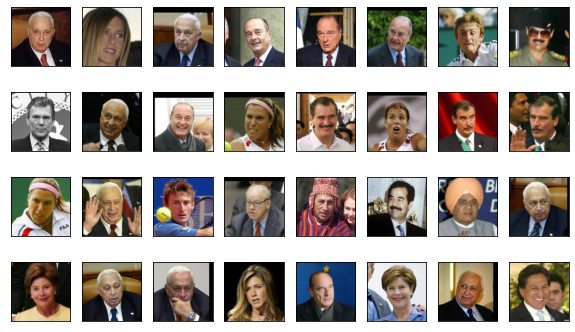

In [11]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:],)
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [12]:
EMB_SIZE = 300

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (11, 11), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [14]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [15]:
BATCH_SIZE = 64
NUM_EPOCHS = 300

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [16]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [17]:
%%time

iteration_in_epoch = len(train_x) // BATCH_SIZE * 10
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % iteration_in_epoch == 0:
        # print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
        print(f'Epoch: {iteration // iteration_in_epoch * 10}, Loss: {loss_value.numpy()}')

Epoch: 0, Loss: 77.12936401367188
Epoch: 10, Loss: 16.13789176940918
Epoch: 20, Loss: 13.644311904907227
Epoch: 30, Loss: 6.476346015930176
Epoch: 40, Loss: 10.800071716308594
Epoch: 50, Loss: 8.726262092590332
Epoch: 60, Loss: 7.958043098449707
Epoch: 70, Loss: 6.136770725250244
Epoch: 80, Loss: 7.203736782073975
Epoch: 90, Loss: 7.550009250640869
Epoch: 100, Loss: 2.7211194038391113
Epoch: 110, Loss: 4.1890058517456055
Epoch: 120, Loss: 4.057277679443359
Epoch: 130, Loss: 0.8440195322036743
Epoch: 140, Loss: 0.4217497408390045
Epoch: 150, Loss: 2.092845916748047
Epoch: 160, Loss: 2.2188773155212402
Epoch: 170, Loss: 0.5754436254501343
Epoch: 180, Loss: 5.245180130004883
Epoch: 190, Loss: 0.5745362639427185
Epoch: 200, Loss: 4.1587629318237305
Epoch: 210, Loss: 2.860898494720459
Epoch: 220, Loss: 0.9692877531051636
Epoch: 230, Loss: 0.0
Epoch: 240, Loss: 3.60042142868042
Epoch: 250, Loss: 1.604170799255371
Epoch: 260, Loss: 0.0
Epoch: 270, Loss: 0.03520240634679794
Epoch: 280, Loss: 0

## Получение эмбеддингов для тестовой выборки

In [18]:
NUM_FOR_TEST = 1000

In [19]:
test_x_splited = np.array_split(test_x, len(test_x)// 50 + 1)

In [20]:
def prediction(test_x_splited):
    preds = []
    for test in test_x_splited:
        preds.extend(model(test))
    return preds

test_embs = prediction(test_x_splited)


## Функция для визуализации эмбеддингов

In [21]:
def draw_embeddings(X_embedded, targets, labels):
    markers = [".","o","v","^","<",">","1","2"]
    colors = ['red', 'blue', 'green',  'black', 'purple', 'orange']
    col_mark = [(color,marker) for marker in markers for color in colors]
    plt.figure(figsize=(10, 10))
    cntr = 0
    # for class_idx in range(np.max(targets)+1):
    for class_idx in set(targets):
        cntr +=1
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(
            X_embedded_class[:,0], 
            X_embedded_class[:,1], 
            c=col_mark[cntr][0], 
            marker=col_mark[cntr][1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов MNIST в 2D пространстве с помощью TSNE

In [22]:
test_x_flat = test_x[:NUM_FOR_TEST].reshape(-1, 250*250*3)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat)
labels_for_viz = test_y[:NUM_FOR_TEST]

In [23]:
np.max(labels_for_viz)+1

2207

In [24]:
test_x.shape

(252, 250, 250, 3)

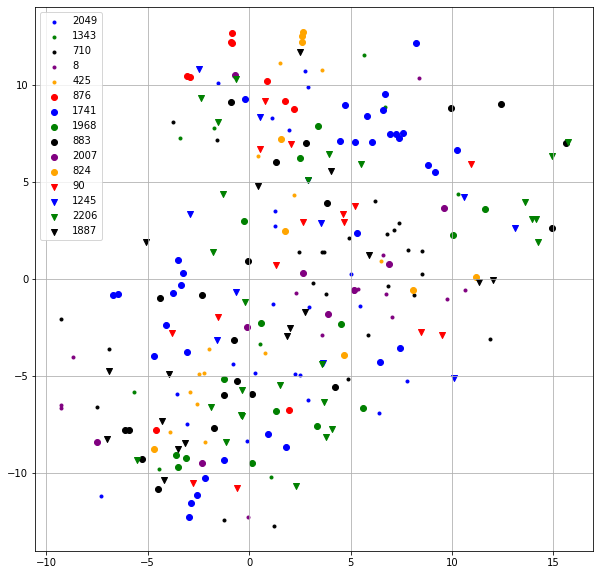

In [25]:
draw_embeddings(test_x_2D, labels_for_viz, list(set(test_y[:NUM_FOR_TEST])))

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [26]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:NUM_FOR_TEST])
labels_for_viz = test_y[:NUM_FOR_TEST]

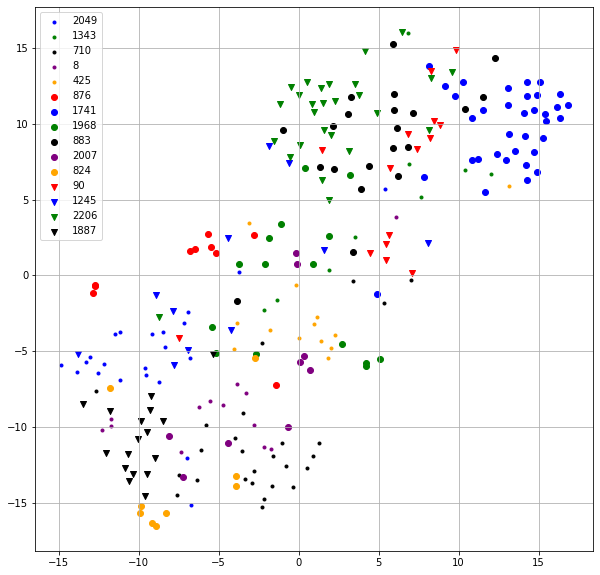

In [27]:
draw_embeddings(test_embs_2D, labels_for_viz, list(set(test_y[:NUM_FOR_TEST])))

In [28]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath)
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    return img


img_a1 = load_and_prepare_image('/content/gdrive/MyDrive/face_samples/robert_deniro_1.jpg')
img_a2 = load_and_prepare_image('/content/gdrive/MyDrive/face_samples/robert_deniro_2.jpg')
img_b1 = load_and_prepare_image('/content/gdrive/MyDrive/face_samples/bred_pitt_1.jpg')

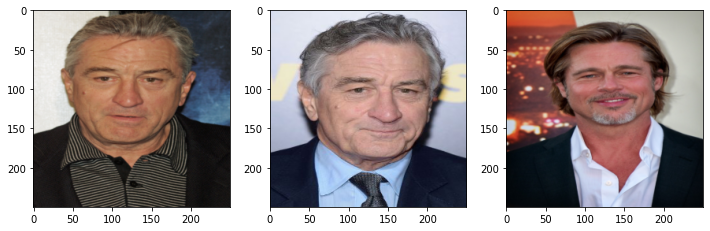

In [29]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,:])
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,:])
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,:])
plt.show()

In [30]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [31]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  4.720933623678139
A2 <-> B1:  7.878769714049983
A1 <-> B1:  7.316819178817242


Выводы примерно такие, я вижу проблемму в несбалансированности данных. я беру 15 человек и делаю для каждого не меньше 15 фото. При лоссе который мы сделали на уроке, он будет плох для большого числа классов. Так как вероятность что мы будем случайно брать фото одного класса будет обратно пропорциональна количеству классов. В итоге сетка получит крайне несбалансированный датасет.

 Мы добавили дополнительно фото Роберта Дениро и Бреда Питта, Сетка их никогда не видела, но даже обученная на 15 людях она дает предпочтение 2м Дениро. Что не плохо. Нужно подумать как сделать датасет тако что бы подавать примерно одинаковое количество пар одного класса и разных, пока идей нету.